In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#from monetio.models import hysplit

In [3]:
from monetio.models import hysplit

In [4]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
from utilvolc import ashapp

In [5]:
from utilvolc.ashapp import ashinverse

In [6]:
# 10/14/2021 rerun with more particles.
# was using numpar=2000
# switch to using numpar=20,000
# was seeing 'steps' in the CDF.
# Also reduce run time from 36h to 24 h.

numpar = 241715
mass = 2.75e10  #grams?
masspar = mass/numpar
print('mass on one particle {}'.format(masspar))
area = 0.1 * 0.1 * 111e3 * 111e3 * np.cos(55*np.pi/180.0)
print('area {} m2'.format(area))
massload = masspar / area
print('mass loading from one particle {}'.format(massload))

mass on one particle 113770.34937840018
area 70670352.72281241 m2
mass loading from one particle 0.0016098738013185982


In [7]:
os.chdir('/hysplit-users/alicec/projects/bezy/notebooks/')
projdir = os.getcwd().replace('notebooks','')

vloc = [160.587,55.978]
tag ='B'
#ens = ['gep{:02d}'.format(x) for x in np.arange(1,31)]
#ens.append('gec00')
#ens=['gep04','gep03']

#----------------------------------------------------------------
# locations and names of netcdf files with cdump output.
tdir = os.path.join(projdir,'data')
fnamelist  = ['xrfile.invbezy{}.nc'.format(tag)]
tdirlist = [tdir]

#----------------------------------------------------------------
configdir = os.path.join(projdir,'RunB')
configfile = 'config.invbezy{}.txt'.format(tag)

#-----------------------------------------------------------------
# location of volcat files
vdir = os.path.join(projdir,'data','volcat')
# volcano id to locate
vid = 'v300250'
#-----------------------------------------------------------------
# Location of inverse algorithm output
#wpath = os.getcwd()
wdir = os.path.join(projdir,'RunB')
#print(wpath)
#cdir = '../Run{}/'.format(tag)
#wdir = '../Run{}/'.format(tag,tag)
#sdir = os.path.join(wdir,'RunM_1_2_3_4_TF')
name = 'out.dat'
name2 = 'out2.dat'
#------------------------------------------------------------------

# name to write emit-times file to.
emit_file_name = '{}emit_Run{}4.txt'.format(wdir,tag)
tcm_name_base = 'run{}zzz.tcm.txt'.format(tag)
figbase = 'Run{}4'.format(tag)

#-------------------------------------------------------------------
#

execdir = os.path.join(projdir,'Inverse_240')
hysplitdir = os.path.join(projdir,'hysplit')
#execdir = mdir+'/Inverse_'
print(execdir, hysplitdir)
print(vdir)
#

datadir = os.path.join(projdir, 'data')

/hysplit-users/alicec/projects/bezy/Inverse_240 /hysplit-users/alicec/projects/bezy/hysplit
/hysplit-users/alicec/projects/bezy/data/volcat


In [8]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,21,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(0,10):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 21, 0), datetime.datetime(2020, 10, 21, 22, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]


In [37]:
# initiate the InverseAshEns object
%autoreload
inverse = ai.InverseAshEns(tdirlist,fnamelist,vdir,vid,configdir=configdir,configfile=configfile,verbose=False)
inverse.add_phash({'p060':1})

In [38]:
inverse.phash

{'p060': 1}

In [39]:
print(inverse.invlist[0].get_time(2))
print(inverse.invlist[0].get_time(4))

2020-10-21 21:00:00
2020-10-21 23:00:00


In [40]:
%autoreload
inverse.set_directory(wdir,execdir,datadir,hysplitdir)
inverse.print_directories()

Working directory, wdir :/hysplit-users/alicec/projects/bezy/RunB
execdir :/hysplit-users/alicec/projects/bezy/Inverse_240
hysplitdir :/hysplit-users/alicec/projects/bezy/hysplit
subdir :/hysplit-users/alicec/projects/bezy/RunB
vdir :/hysplit-users/alicec/projects/bezy/data/volcat
datadir :/hysplit-users/alicec/projects/bezy/data


In [41]:
inva = inverse.invlist[0]
inva.cdump.coords

Coordinates:
  * time       (time) datetime64[ns] 2020-10-21T19:00:00 ... 2020-10-22T11:00:00
  * z          (z) int64 1523 3047 4571 6095 7619 9143 10667 12191 13715 15239
  * y          (y) int64 376 377 378 379 380 381 382 ... 480 481 482 483 484 485
  * x          (x) int64 866 867 868 869 870 871 872 ... 947 948 949 950 951 952
  * ens        (ens) object '102119_2880' '102119_3880' ... '102200_12880'
    source     <U13 'Line to 14 km'
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...

In [42]:
# add in the relavant VOLCAT observations
%autoreload
#dlist = [[datetime.datetime(2020,10,22,9),datetime.datetime(2020,10,22,10)]]
for drange in dlist:
    print(drange)
    inverse.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 21, 0), datetime.datetime(2020, 10, 21, 22, 0)]
[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]


In [43]:
for tii in [1,2,3,4,5,6,7,8,9,10,11]:
    print('time {} : {}'.format(tii,inverse.invlist[0].get_time(tii)))


time 1 : 2020-10-21 20:00:00
time 2 : 2020-10-21 21:00:00
time 3 : 2020-10-21 22:00:00
time 4 : 2020-10-21 23:00:00
time 5 : 2020-10-22 00:00:00
time 6 : 2020-10-22 01:00:00
time 7 : 2020-10-22 02:00:00
time 8 : 2020-10-22 03:00:00
time 9 : 2020-10-22 04:00:00
time 10 : 2020-10-22 05:00:00
time 11 : 2020-10-22 06:00:00


In [44]:
%autoreload
inverse.invlist[0].print_summary()

Observations availalbe in volcat_avg_hash
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
times in cdump file
2020 10 21 19:00z
2020 10 21 20:00z
2020 10 21 21:00z
2020 10 21 22:00z
2020 10 21 23:00z
2020 10 22 00:00z
2020 10 22 01:00z
2020 10 22 02:00z
2020 10 22 03:00z
2020 10 22 04:00z
2020 10 22 05:00z
2020 10 22 06:00z
2020 10 22 07:00z
2020 10 22 08:00z
2020 10 22 09:00z
2020 10 22 10:00z
2020 10 22 11:00z


10 bezyB
tii 10


/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


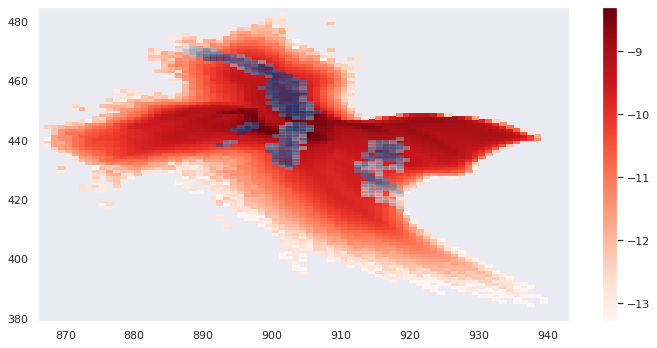

In [45]:
%autoreload
#gep10, gep16 looks good at tii=6.
#gep24 possibly looks ok.
zlevel=None  #index 'ensemble'
           #if None then sum along the ens. dimension which shows contributions from all inv. runs.
tii=10
#zlevel=None
%autoreload
ax = inverse.compare_plotsA(daterange=dlist[0],tii=tii,zii=zlevel)
#plt.gca()
#ax.plot(160.587,55.978,'y^')
#plt.show()


In [32]:
%autoreload
inverse.set_concmult(1)

# Automatic Runs

In [46]:
inverse.subdir

'/hysplit-users/alicec/projects/bezy/RunB'

In [47]:
def makerun(invserse, tii,remove_cols, remove_rows, remove_sources,remove_ncs):
    print("Running makerun")
    inverse.make_tcm_mult(tii,remove_cols=remove_cols, remove_rows=remove_rows, remove_sources=remove_sources,remove_ncs=remove_ncs)
    runtag = ai.create_runtag(tag,tii,remove_cols, remove_rows, remove_sources,remove_ncs=remove_ncs)
    inverse.set_subdirectory(runtag)
    print('In subdirectory', inverse.subdir)
    tcmstr = inverse.write_tcm(os.path.join(inverse.subdir, tcm_name_base.replace('zzz','4')))
    inverse.run_tcm()
    
    eii=None
    unit='g/h'
    unit='kg/s'
    inverse.plot_outdat_ts(eii,unit=unit)
    #plt.show()
    #inverse.plot_outdat_ts(eii,profile=True)
    print('HERE runtag is ', runtag)
    inverse.save_emis(runtag+'.csv')


## Run with all previous and just two previous

In [ ]:
%autoreload
# creates emit-times, CONTROL and SETUP files for HYSPLIT runs.
# Note that warning that meteorological files not found is ok.

%autoreload
print('here')
tiilist = [[2,3],[2,3,4],[2,3,4,5],[2,3,4,5,6],[2,3,4,5,6,7],[2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9],
           [2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11]]  #times to assimilate in inversion algorithm.
#tiilist = [[2,3]]
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=7
for tii in tiilist:
    print('tii', tii)
    makerun(inverse, tii,remove_cols,remove_rows,remove_sources,remove_ncs)
    inverse.make_efile(vloc=vloc)
    inverse.run_hysplit()


tiilist = [[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11]]
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=7
for tii in tiilist:
    makerun(inverse, tii,remove_cols,remove_rows,remove_sources,remove_ncs)
    inverse.make_efile(vloc=vloc)
    inverse.run_hysplit()

here
tii [2, 3]
Running makerun
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
In subdirectory /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw7


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:1094: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if remove_cols:
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:1095: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nmax = t3.shape[1]
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:1109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object

bezyB


No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


HERE runtag is  RunB_2_3_TFw7
length 1
self subdir is /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw7
saving emissions in  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw7/RunB_2_3_TFw7.csv
saving  emissions to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw7/RunB_2_3_TFw7.csv
working on  0 1
using particle size  {'p060': 1}
ZZZZ
splist dict_keys(['p060'])
(datetime.datetime(2020, 10, 21, 19, 0), 2880.0, 2.096505091599114e-07) 1
(datetime.datetime(2020, 10, 21, 19, 0), 3880.0, 45.3178403748571) 1
(datetime.datetime(2020, 10, 21, 19, 0), 4880.0, 1268.43043760111) 1
(datetime.datetime(2020, 10, 21, 19, 0), 5880.0, 236217628.838328) 1
(datetime.datetime(2020, 10, 21, 19, 0), 6880.0, 32877.3567289393) 1
(datetime.datetime(2020, 10, 21, 19, 0), 7880.0, 11922.5074615714) 1
(datetime.datetime(2020, 10, 21, 19, 0), 8880.0, 3139191076.71634) 1
(datetime.datetime(2020, 10, 21, 19, 0), 9880.0, 2833.77398494474) 1
(datetime.datetime(2020, 10, 21, 19, 0), 10880.0, 12.47675224670

## For comparision with RunC

In [ ]:
# No clear sky values
%autoreload
tiilist = [[2,3],[2,3,4],[2,3,4,5],[2,3,4,5,6],[2,3,4,5,6,7],[2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9],
           [2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11],
           [4,5,6]]  #times to assimilate in inversion algorithm.
tiilist = [[4,5,6]]
remove_cols=True    # removes columns with no model values in them.
remove_rows=False   # removes clear sky observations
remove_sources = False
remove_ncs=7
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)

#remove_rows=True
#remove_ncs=0
#for tii in tiilist:
#    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)

#remove_rows=False
#remove_ncs=0
#for tii in tiilist:
#    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)

In [ ]:
%autoreload
tiilist = [[2,3],[2,3,4],[2,3,4,5],[2,3,4,5,6],[2,3,4,5,6,7],[2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9],
           [2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11],
           [4,5,6]]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False   # removes clear sky observations
remove_sources = False
remove_ncs=5
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=True
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=False
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
    
    
tiilist = [[7,8],[9,10,11],[2,3,4,5,6,7,8,9,10,11]]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=7
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=True
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=False
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)  
    

# Looking at inidividual inversions

In [ ]:
%autoreload
tii = [2,3]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=5
#remove_sources = ['12880']  # this would remove top vertical level from consideration.
#inverse.make_tcm_mult([1,2,3,4],remove_cols=True,remove_rows=False,remove_sources=['12880'])
inverse.make_tcm_mult(tii,remove_cols=remove_cols, remove_rows=remove_rows, remove_sources=remove_sources,remove_ncs=remove_ncs)
runtag = ai.create_runtag(tag,tii,remove_cols, remove_rows, remove_sources,remove_ncs=remove_ncs)

# set the subdirectory for this TCM run.
#subdir = inverse.set_sub_directory(runtag)
#print('setting subdirectory {}'.format(subdir))

In [ ]:
print(runtag)

In [ ]:
numpar = 20000  # number of particles released per hour.
delt = 5 # time step
tave = 1 # 1 h time average
hres = 0.1 # 0.1 degree horizontal resolution.
rate = 1 # 1 unit mass per hour
particle_mass = rate / numpar  #how much unit mass each particle has
area = (hres * 111e3)**2  # area in meters squared for mass loading grid.
mass_one = particle_mass / area  # unit mass / m2 for one particle in grid box.
mass_one_one = mass_one / (tave*60 / delt)  # smallest mass loading possible with one particle for one time step
print(mass_one_one)  # one particle for one time step
print(mass_one)      # one particle in area.

In [ ]:
%autoreload
inverse.plot_tcm()
inverse.invlist[0].tcm.shape


In [ ]:
#hysplitdir = '/hysplit-users/alicec/FBamcArea/exec/'
#inverse.set_directory(wdir,execdir,hysplitdir)
inverse.set_subdirectory(runtag)

In [ ]:
%autoreload
tcmstr = inverse.write_tcm(os.path.join(inverse.subdir, tcm_name_base.replace('zzz','4')))
#print(tcmstr)

In [ ]:
%autoreload
#hysplitdir = '/hysplit-users/alicec/FBamcArea/exec/'
#inverse.set_directory(wdir,execdir,hysplitdir)
inverse.run_tcm()

In [ ]:
# Now run the inverse model.

# open the Parameters_in.dat file and set N_ctrl, Nx_ctrl and lbfgs_nbd to
# the number shown for N_ctrl above.

# copy the tcm file to TCM_sum.csv

# run new_lbfgsb.x

In [ ]:
10**0.0007

In [ ]:
%autoreload
inverse.plot_outdat(eii=None)

In [ ]:
print(inverse.make_tcm_names())
print(inverse.subdir)

In [ ]:
%autoreload

eii=None
unit='g/h'
unit='kg/s'
inverse.plot_outdat_ts(eii,unit=unit)
plt.show()
inverse.plot_outdat_ts(eii,profile=True)
inverse.save_emis(runtag+'.csv')
#ax = plt.gca()
#ax.set_ylim(0,10000)

In [ ]:
#%autoreload
#inverse.sourcehash = ai.get_sourcehash(configdir,configfile)

In [ ]:
%autoreload
unit='kg/s'
#unit='g/h'
iii=0
print(inverse.taglist[iii])
ilist =  inverse.read_outdat()
df = ilist[iii].get_emis()
vals = inverse.invlist[iii].make_outdat(df)
inverse.invlist[iii].plot_outdat(vals,log=False,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions_log.png'.format(figbase))
plt.show()
inverse.invlist[0].plot_outdat(vals,log=True,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions.png'.format(figbase))


In [ ]:
inverse.invlist[0].inp

In [ ]:
%autoreload
inverse.print_directories()

In [ ]:
%autoreload
# creates emit-times, CONTROL and SETUP files for HYSPLIT runs.
# Note that warning that meteorological files not found is ok.
inverse.make_efile(vloc=vloc)

In [ ]:
%autoreload
inverse.run_hysplit()

# Creating netcdf files from cdump

In [ ]:
runtag = 'RunB_5_TT'
runtag = 'RunB_2_3_4_TF'
runtag = 'RunB_2_3_4_TT'
runtag = 'RunB_7_TT'
inverse.set_subdirectory(runtag)

In [ ]:
%autoreload
# converts cdump to netcdf file.
#dset = inverse.create_emit_output(inverse.subdir + '/Run{}.nc'.format(tag))

In [ ]:
#for attr in dset.attrs: print(type(dset.attrs[attr]), attr)

In [ ]:
blist = []
for iii, subdir in enumerate(runtag):
    #print(subdir)
    inverse.set_subdirectory(subdir)
    #print(inverse.subdir)
    if os.path.isfile(os.path.join(inverse.subdir,'cdump.bezyB')):
       blist.append([os.path.join(inverse.subdir,'cdump.bezyB'),'gfs0p25',subdir])


#cdir = '/hysplit-users/alicec/projects/bezy/RunB/'
#tags = ['RunC_2_3_4_TFw5', 'RunC_4_5_6_TFw5', 'RunC_7_8_TFw7','RunC_9_10_11_TFw7']
#name = 'cdump.bezyC'
#for tag in tags:
#    blist.append((os.path.join(cdir,tag,name),'gfs0p25',tag))
    
cdir = '/hysplit-users/alicec/projects/bezy/RunC/'
tags = ['RunC_2_3_4_TFw5', 'RunC_4_5_6_TFw5', 'RunC_7_8_TFw7','RunC_9_10_11_TFw7']
name = 'cdump.bezyC'
for tag in tags:
    blist.append((os.path.join(cdir,tag,name),'gfs0p25',tag))



cdir = '/hysplit-users/alicec/projects/bezy/RunD/'
tags = ['RunD_2_3_4_TFw5', 'RunD_4_5_6_TFw5', 'RunD_7_8_TFw7','RunD_9_10_11_TFw7']
tags.append('RunD_2_3_4_5_6_7_8_9_10_11_TFw7')
tags.append('RunD_2_3_4_5_6_7_8_9_10_11_TT')
name = 'cdump.ezyD1'
for tag in tags:
    blist.append((os.path.join(cdir,tag,name),'gfs0p25',tag))

for bl in blist: 
    print(bl)
    print(os.path.isfile(bl[0]))
#dset = hysplit.combine_dataset(blist)

In [ ]:
dset.ens.values
dset.to_netcdf(os.path.join(inverse.wdir,'RunGFS2.nc'))

In [ ]:
%autoreload
unit='kg/s'
#unit='g/h'
iii=0
print(inverse.taglist[iii])
ilist =  inverse.read_outdat()
df = ilist[iii].get_emis()
vals = inverse.invlist[iii].make_outdat(df)
inverse.invlist[iii].plot_outdat(vals,log=False,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions_log.png'.format(figbase))
plt.show()
inverse.invlist[0].plot_outdat(vals,log=True,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions.png'.format(figbase))

In [ ]:
v8, c8 = inverse.invlist[0].get_pair(4)

In [ ]:
v8.plot.pcolormesh()

In [ ]:
test1 = xr.where(test>0,True,False)
test2 = xr.where(v8>0,True,False)

In [ ]:
spread=4
test = v8.rolling(x=spread,center=True).max()
test = test.rolling(y=spread,center=True).max()
test.plot.pcolormesh()

In [ ]:
test1

In [ ]:
np.all([test1,test2],axis=0).shape

In [ ]:
test3 = xr.where(np.any([test1,test2],axis=0), v8, -1)

In [ ]:
test3.plot.pcolormesh()

In [ ]:
1.5e4*1e3*3600 / 1e12

In [ ]:
datetime.timedelta(hours=1)

In [ ]:
import xarray as xr

In [ ]:
test = xr.open_dataset('../data/xrfile.ensCylBezyA2.nc')

In [ ]:
test

In [ ]:
test.z.values

In [ ]:
1523+500

In [ ]:
3047-1523